## Data Preparation

In [1]:
# Open File
import pandas as pd
import seaborn.objects as so

sheet_url = 'https://docs.google.com/spreadsheets/d/19h-r3Yt_8hF7_XPX3eaNRKUd1TwLMINUvsafSTVhLV0/edit#gid=0'
sheet_name = 'Sheet1'

sheet_id = (
    sheet_url
    .replace('/d/', '*')
    .replace('/edit', '*')
    .split('*')
)

url = f'https://docs.google.com/spreadsheets/d/{sheet_id[1]}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

raw_data = pd.read_csv(url)

raw_data.head()


,div,tx,sample,Tfr1,Slc16a2,Slco1c1,Crym,Pvalb,Klf9,Hr,Nrgn,Dio2
0,11,ctl,1,0.887615,1.014553,NaN,1.214971,1.088394,0.910328,0.867883,0.857594,0.735769
1,11,ctl,5,1.019602,0.868310,NaN,0.812623,0.900615,0.968926,0.760791,1.034093,1.077228
2,11,ctl,9,1.092783,1.117137,NaN,0.972406,1.010990,1.120746,1.371326,1.108313,1.187003
3,11,ctl,59,0.986020,0.853487,0.831944,1.195966,0.912644,0.954004,0.949874,1.024060,0.958570
4,11,ctl,60,0.901056,1.093988,NaN,1.031685,1.026778,1.073310,1.169432,0.996057,0.913170


Tidy the `raw_data`, convert to long form `data`
* Declare indexing columns to appropriate data types, instead of pandas defaults
* Melt `raw_data` to long form `data` by using genes as variables. 
* Set a multi-index
* Create the `indexing` function to easily parse the multi-index data in different ways

In [2]:
# Convert indexing columns to appropriate data types. With sample as str because it is not useful as an int
raw_data['div'] = raw_data['div'].astype('str')
raw_data['tx'] = raw_data['tx'].astype('str')
raw_data['sample'] = raw_data['sample'].astype('str')

# Tidy data
data = (raw_data
        .melt(id_vars=['div', 'tx', 'sample'],
              var_name='gene',
              value_name='mrna'
              )
        .set_index(['div', 'tx', 'sample', 'gene'])
        )

# Place here to update indexing arguments relative to index set above


def indexing(
        data=data,
        div=slice(None),
        tx=slice(None),
        sample=slice(None),
        gene=slice(None)
):
    """Parse multi-indexed pandas dataframe
    Not passing an argument is equivalent to selecting with : by using slice(None)
    Passing a list (even for a list of length 1) will keep the index, so this is encouraged. 
    Passing a string will drop the index column, but select it.
    """
    idx = pd.IndexSlice[div, tx, sample, gene]
    return data.loc[idx]


## Plotting with Seaborn Objects

This initalizes plotting functions, and then creates 2 different dicts of `rcparams` to be used with Seaborn objects `so.theme`

In [5]:
from seaborn import axes_style
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib

# Dict of theme parmams:: -- to inspect the themes of seaborn, and thus borrow the rcparams:
# sns.axes_style('ticks')
# Dict of context/plotting size::
# sns.plotting_context('poster')
# https://github.com/mwaskom/seaborn/blob/master/seaborn/rcmod.py#L14

poster_dict = {
    'xtick.bottom': True,
    'xtick.direction': 'out',
    'xtick.color': '0.15',
    'ytick.left': True,
    'ytick.direction': 'out',
    'ytick.color': '.15',
    'axes.grid': True,
    'axes.edgecolor': '0.15',
    'axes.spines.right': False,
    'axes.spines.top': False,
}
ticks_dict = {
    **axes_style("ticks"),
    'axes.spines.right': False,
    'axes.spines.top': False,
}


Currently plotting with seaborn objects has some limitations, but as it improves in the future, I suspect easy to understand and beautiful plots will be easier to create. This block defines the `univariate_plot` function. 

In [23]:
def univariate_plot(
        data=None,
        theme=poster_dict,
        context='talk',
        tick_list=[0.1, 0.5, 0.8, 1, 1.2, 1.5, 2, 3, 4],
        title=None,
        width=8,
        height=4,
):

    p = (
        so.Plot(
            data=data,
            x='gene',
            y='mrna',
            color='tx',
        )
        .facet(row='div', col='gene')
        .share(x=False, y=False)
        # mean Dash
        .add(so.Dash(alpha=0.8), so.Agg(),
             so.Dodge(empty='drop'))
        # SD Range line
        .add(so.Range(alpha=1), so.Est(errorbar='sd'),
             so.Dodge(empty='drop'), so.Shift(x=0.04)
             )
        # raw Dots
        .add(so.Dots(pointsize=7),
             so.Dodge(empty='drop'), so.Jitter(), so.Shift(x=-0.04)
             )
        .scale(
            # y='log',
            y=so.Continuous(trans='log').tick(
                at=tick_list).label(base=None, like="{x:.1f}"),
        )
        .label(
            y="mRNA rel. to avg. ctl",
            x="",
            title=title,
        )
        .layout(size=(width, height))
        .theme(theme)
        # default is 'notebook', others are 'paper','talk',and 'poster'
        .theme(sns.plotting_context(context))
    )
    return p


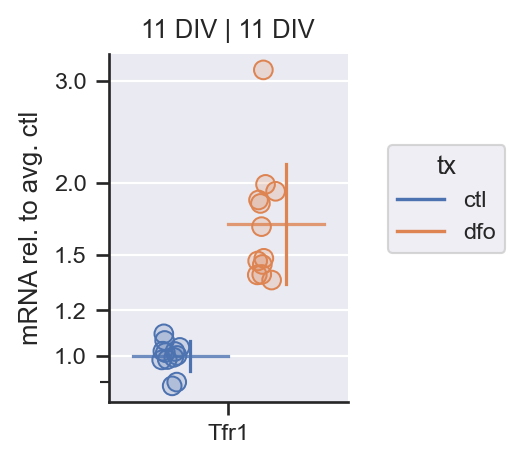

In [27]:
plot_data = indexing(
    data=data,
    div=['11'],
    gene=['Tfr1'],
).reset_index()

plot = univariate_plot(
    data=plot_data,
    title='11 DIV',
    width=2,
    height=2.5,
    theme=poster_dict,
    context='paper'
)

plot.save("11DIV-Tfr1.pdf")  # both display and save the plot


### Classic Seaborn Plotting
import and set theme

In [29]:
# Set Theme
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

sns.set_theme(
    style='ticks',
    context='paper',
    palette='colorblind',
    font_scale=1)


In [44]:
# Plotting using a generalizable function, not sure if I like this though
# will require using indexing() to grab proper data
def box_plot(
        width=None,
        height=None,
        data=indexing(data),
        x_var='gene',
        y_var='mrna',
        hue_var='tx',
        title=None,
        box_cmap='pastel',
        swarm_cmap='colorblind'
):

    plot_data = data.reset_index()

    f, ax = plt.subplots(figsize=(width, height))

    sns.boxplot(data=plot_data,
                x=x_var,
                y=y_var,
                hue=hue_var,
                palette=box_cmap)

    sns.swarmplot(data=plot_data,
                  x=x_var,
                  y=y_var,
                  hue=hue_var,
                  dodge=True,
                  size=8,
                  palette=swarm_cmap)

    key_length = data.reset_index().tx.unique().__len__()
    handles, labels = ax.get_legend_handles_labels()

    ax.legend(handles[:key_length],
              labels[:key_length],
              title="Treatment",
              bbox_to_anchor=(1, 0.5),
              loc='center left')

    ax.set_xlabel('Gene')
    ax.set_ylabel('Relative mRNA')
    ax.set_title(title)
    ax.semilogy(base=10, subs=None)
    # ax.set_yscale('log')
    # #ax.set_yticks([0.5,1,2])
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter()) # https://stackoverflow.com/questions/14530113/set-ticks-with-logarithmic-scale
    # #ax.get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    from matplotlib.ticker import ScalarFormatter, NullFormatter
    for axis in [ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_formatter(ScalarFormatter())
    sns.despine()
    return f


In [45]:
plot_data = indexing(
    data=data,
    div=['11'],
    gene=['Tfr1'],
).reset_index()


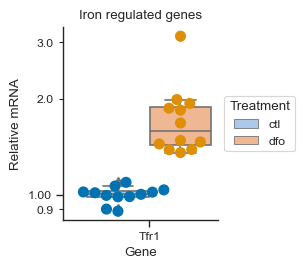

In [47]:
f = box_plot(width=2,
             height=2.5,
             data=plot_data,
             title='Iron regulated genes',
             )
f.savefig('old.pdf')


In [50]:
def viol_plot(
        width=None,
        height=None,
        data=plot_data,
        x_var='gene',
        y_var='mrna',
        hue_var='tx',
        title=None,
        box_cmap='pastel',
        swarm_cmap='colorblind',
):
    f, ax = plt.subplots(figsize=(width, height))
    ax.set_yscale('log')

    sns.stripplot(data=data,
                  x=x_var,
                  y=y_var,
                  hue=hue_var)


In [51]:
viol_plot()


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''